# Summary

Create the `elaspic_training_interface` database and fill it with **interface** training data.

Depends on `interface_load_data`.




# Imports

In [1]:
%run imports.ipynb

2016-07-19 22:59:47.023707


In [2]:
NOTEBOOK_NAME = 'elaspic_standalone_training_interface'
os.environ['NOTEBOOK_NAME'] = NOTEBOOK_NAME

os.environ['DB_PORT'] = '8309'

PDB_DIR = '/home/kimlab1/database_data/pdb/data/data/structures/all/pdb'

In [3]:
%run mysqld.ipynb

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
2016-07-19 22:59:47.216778


In [4]:
os.makedirs(NOTEBOOK_NAME, exist_ok=True)

# Load data

In [5]:
db_remote = datapkg.MySQL(
    connection_string=os.environ['DATAPKG_CONNECTION_STR'], 
    shared_folder=os.environ['NOTEBOOK_NAME'], 
    storage_host=None, 
    echo=False, 
    db_engine='InnoDB'
)

In [6]:
datasets = ['kortemme_baker', 'skempi', 'taipale_ppi', 'taipale_gpca']

DATA = {}
for dataset in datasets:
    DATA[dataset] = pd.read_sql_table(dataset, db_remote.engine, schema='protein_interaction_energy')

In [7]:
DATA['kortemme_baker'].head()

,idx,pdb_id,pdb_chain,partner_pdb_chain,pdb_mutation,uniprot_id,partner_uniprot_id,uniprot_mutation,pfam_id,pfam_clan,ddg_exp
0,1,1a22,A,NaN,M14A,P01241,NaN,M40A,PF00103,CL0053,0.1
1,2,1a22,A,NaN,H18A,P01241,NaN,H44A,PF00103,CL0053,-0.5
2,3,1a22,A,NaN,H21A,P01241,NaN,H47A,PF00103,CL0053,0.2
3,4,1a22,A,NaN,Q22A,P01241,NaN,Q48A,PF00103,CL0053,-0.2
4,5,1a22,A,NaN,F25A,P01241,NaN,F51A,PF00103,CL0053,-0.4


# Kortemme-Baker

In [8]:
kortemme_baker_df = DATA['kortemme_baker'].copy()

In [9]:
kortemme_baker_df['pdb_file'] = (
    PDB_DIR + ('/pdb' + kortemme_baker_df['pdb_id'] + '.ent.gz')
)

In [10]:
kortemme_baker_df_tocalculate = (
    kortemme_baker_df
    .groupby(['pdb_id', 'pdb_file'])
    .agg({'pdb_mutation': lambda x: ':'.join(ascommon.py_tools.unique(x))})
    .reset_index()
)

In [11]:
display(kortemme_baker_df_tocalculate.head())
print(kortemme_baker_df_tocalculate.shape[0])

,pdb_id,pdb_file,pdb_mutation
0,1a22,/home/kimlab1/database_data/pdb/data/data/stru...,M14A:H18A:H21A:Q22A:F25A:D26A:Q29A:Y42A:L45A:Q...
1,1a4y,/home/kimlab1/database_data/pdb/data/data/stru...,W261A:W263A:E287A:S289A:W318A:K320A:E344A:W375...
2,1ahw,/home/kimlab1/database_data/pdb/data/data/stru...,Y156A:T167A:T170A:L176A:D178A:T197A:V198A:N199A
3,1brs,/home/kimlab1/database_data/pdb/data/data/stru...,K27A:D54A:N58A:R59A:E60A:E73A:R87A:H102A:Y29A:...
4,1bxi,/home/kimlab1/database_data/pdb/data/data/stru...,N24A:D26A:T27A:S28A:S29A:E30A:E31A:E32A:L33A:V...


19


In [12]:
system_command_template = """\
mkdir -p '{tempdir}' && \
cd '{tempdir}' && \
elaspic run -p '{pdb_file}' -m '{mutation}' -n 1 \
    --pdb_dir='/home/kimlab1/database_data/pdb/data/data/structures/divided/pdb/' \
    --blast_db_dir='/home/strokach/databases/blast/db' \
    --archive_dir='/home/kimlab1/database_data/elaspic_v2/'
"""

SUFFIX = '_1'
JOB_NAME = 'elaspic_run_kortemme_baker{}'.format(SUFFIX)

kortemme_baker_df_tocalculate['system_command'] = (
    kortemme_baker_df_tocalculate.apply(
        lambda x: system_command_template.format(
            tempdir=op.abspath(op.join(NOTEBOOK_NAME, JOB_NAME, x['pdb_id'].lower())),
            pdb_file=x['pdb_file'],
            mutation=x['pdb_mutation']),
        axis=1)
)

In [13]:
display(kortemme_baker_df_tocalculate.head())
print(kortemme_baker_df_tocalculate.shape[0])

,pdb_id,pdb_file,pdb_mutation,system_command
0,1a22,/home/kimlab1/database_data/pdb/data/data/stru...,M14A:H18A:H21A:Q22A:F25A:D26A:Q29A:Y42A:L45A:Q...,mkdir -p '/home/kimlab1/database_data/biodb/re...
1,1a4y,/home/kimlab1/database_data/pdb/data/data/stru...,W261A:W263A:E287A:S289A:W318A:K320A:E344A:W375...,mkdir -p '/home/kimlab1/database_data/biodb/re...
2,1ahw,/home/kimlab1/database_data/pdb/data/data/stru...,Y156A:T167A:T170A:L176A:D178A:T197A:V198A:N199A,mkdir -p '/home/kimlab1/database_data/biodb/re...
3,1brs,/home/kimlab1/database_data/pdb/data/data/stru...,K27A:D54A:N58A:R59A:E60A:E73A:R87A:H102A:Y29A:...,mkdir -p '/home/kimlab1/database_data/biodb/re...
4,1bxi,/home/kimlab1/database_data/pdb/data/data/stru...,N24A:D26A:T27A:S28A:S29A:E30A:E31A:E32A:L33A:V...,mkdir -p '/home/kimlab1/database_data/biodb/re...


19


In [14]:
system_command = kortemme_baker_df_tocalculate.loc[0, 'system_command']
print(system_command)

mkdir -p '/home/kimlab1/database_data/biodb/recipes/elaspic_training_set/notebooks/elaspic_standalone_training_interface/elaspic_run_kortemme_baker_1/1a22' && cd '/home/kimlab1/database_data/biodb/recipes/elaspic_training_set/notebooks/elaspic_standalone_training_interface/elaspic_run_kortemme_baker_1/1a22' && elaspic run -p '/home/kimlab1/database_data/pdb/data/data/structures/all/pdb/pdb1a22.ent.gz' -m 'M14A:H18A:H21A:Q22A:F25A:D26A:Q29A:Y42A:L45A:Q46A:S51A:E56A:S62A:N63A:R64A:E65A:Q68A:Y164A:R167A:K168A:D171A:K172A:E174A:T175A:F176A:R178A:I179A:R183A:E186A:R243A:E244A:R270A:R271A:T273A:Q274A:E275A:W276A:W280A:S298A:S302A:I303A:W304A:I305A:E320A:K321A:S324A:D326A:E327A:D364A:I365A:Q366A:K367A:W369A:V371A:T395A:Q416A:R417A:N418A:S419A:E242A:N272A:T277A:T301A:T394A:K415A' -n 1     --pdb_dir='/home/kimlab1/database_data/pdb/data/data/structures/divided/pdb/'     --blast_db_dir='/home/strokach/databases/blast/db'     --archive_dir='/home/kimlab1/database_data/elaspic_v2/'



## SGE

In [15]:
PATH = (
    '/home/kimlab1/strokach/anaconda/bin:/usr/local/bin:/bin:/usr/bin:/usr/local/sbin:/usr/sbin:/sbin'
)

js_be = ascommon.cluster_tools.JobSubmitter(
    JOB_NAME, 'sge://:@192.168.6.201', op.abspath(NOTEBOOK_NAME),
    email='ostrokach@gmail.com', force_new_folder=False,
    nproc=1, queue='medium', walltime='8:00:00', mem='6G',
    env={'PATH': PATH}
)

In [16]:
js_be.job_name

'elaspic_run_kortemme_baker_1'

In [17]:
kortemme_baker_df_tocalculate.reset_index()[['pdb_id', 'system_command']].values.tolist()[:1]

[['1a22',
  "mkdir -p '/home/kimlab1/database_data/biodb/recipes/elaspic_training_set/notebooks/elaspic_standalone_training_interface/elaspic_run_kortemme_baker_1/1a22' && cd '/home/kimlab1/database_data/biodb/recipes/elaspic_training_set/notebooks/elaspic_standalone_training_interface/elaspic_run_kortemme_baker_1/1a22' && elaspic run -p '/home/kimlab1/database_data/pdb/data/data/structures/all/pdb/pdb1a22.ent.gz' -m 'M14A:H18A:H21A:Q22A:F25A:D26A:Q29A:Y42A:L45A:Q46A:S51A:E56A:S62A:N63A:R64A:E65A:Q68A:Y164A:R167A:K168A:D171A:K172A:E174A:T175A:F176A:R178A:I179A:R183A:E186A:R243A:E244A:R270A:R271A:T273A:Q274A:E275A:W276A:W280A:S298A:S302A:I303A:W304A:I305A:E320A:K321A:S324A:D326A:E327A:D364A:I365A:Q366A:K367A:W369A:V371A:T395A:Q416A:R417A:N418A:S419A:E242A:N272A:T277A:T301A:T394A:K415A' -n 1     --pdb_dir='/home/kimlab1/database_data/pdb/data/data/structures/divided/pdb/'     --blast_db_dir='/home/strokach/databases/blast/db'     --archive_dir='/home/kimlab1/database_data/elaspic_v2/'\n"

## Resubmit failed

In [18]:
# Get job status
results_df = (
    js_be.job_status(
        kortemme_baker_df_tocalculate.reset_index()[['pdb_id', 'system_command']].values.tolist()))
print(Counter(results_df['status']))

Counter({'misformed output': 19})


In [19]:
# Job statistics
failed = (
    set(results_df[~results_df['status'].isin(['misformed output', 'done'])]['job_id'])
)
system_commands_remaining = (
    kortemme_baker_df_tocalculate[
        (kortemme_baker_df_tocalculate['pdb_id'].isin(failed))
    ]
)
print(len(system_commands_remaining))

0


In [20]:
assert system_commands_remaining.empty

In [21]:
results_df

,job_id,status,~system_command
0,1a22,misformed output,mkdir -p '/home/kimlab1/database_data/biodb/re...
1,1a4y,misformed output,mkdir -p '/home/kimlab1/database_data/biodb/re...
2,1ahw,misformed output,mkdir -p '/home/kimlab1/database_data/biodb/re...
3,1brs,misformed output,mkdir -p '/home/kimlab1/database_data/biodb/re...
4,1bxi,misformed output,mkdir -p '/home/kimlab1/database_data/biodb/re...
5,1cbw,misformed output,mkdir -p '/home/kimlab1/database_data/biodb/re...
6,1dan,misformed output,mkdir -p '/home/kimlab1/database_data/biodb/re...
7,1dfj,misformed output,mkdir -p '/home/kimlab1/database_data/biodb/re...
8,1dn2,misformed output,mkdir -p '/home/kimlab1/database_data/biodb/re...
9,1f47,misformed output,mkdir -p '/home/kimlab1/database_data/biodb/re...


## Results

### Read results

In [22]:
ls $NOTEBOOK_NAME/$JOB_NAME/1a22/.elaspic

1A22AB.pdb             mutation_A_Q46A.json   mutation_B_N418A.json
1A22A.fasta            mutation_A_Q68A.json   mutation_B_Q274A.json
1A22A.pdb              mutation_A_R167A.json  mutation_B_Q366A.json
1A22B.fasta            mutation_A_R178A.json  mutation_B_Q416A.json
1A22B.pdb              mutation_A_R183A.json  mutation_B_R243A.json
model/                 mutation_A_R64A.json   mutation_B_R270A.json
model.json             mutation_A_S51A.json   mutation_B_R271A.json
mutation_A_D171A.json  mutation_A_S62A.json   mutation_B_R417A.json
mutation_A_D26A.json   mutation_A_T175A.json  mutation_B_S298A.json
mutation_A_E174A.json  mutation_A_Y164A.json  mutation_B_S302A.json
mutation_A_E186A.json  mutation_A_Y42A.json   mutation_B_S324A.json
mutation_A_E56A.json   mutation_B_D326A.json  mutation_B_S419A.json
mutation_A_E65A.json   mutation_B_D364A.json  mutation_B_T273A.json
mutation_A_F176A.json  mutation_B_E242A.json  mutation_B_T277A.json
mutation_A_F25A.json   mutation_B_E244A.json  mu

In [23]:
def load_json(file):
    with open(file, 'rt') as ifh:
        return json.load(ifh)


kortemme_baker_df['mutation_json'] = (
    kortemme_baker_df[['pdb_id', 'pdb_chain', 'pdb_mutation']].apply(
        lambda x: load_json(
            op.join(
                NOTEBOOK_NAME,
                JOB_NAME,
                x[0].lower(),
                '.elaspic',
                'mutation_{}_{}.json'.format(x[1], x[2]))), 
        axis=1)
)

In [24]:
kortemme_baker_df.head()

,idx,pdb_id,pdb_chain,partner_pdb_chain,pdb_mutation,uniprot_id,partner_uniprot_id,uniprot_mutation,pfam_id,pfam_clan,ddg_exp,pdb_file,mutation_json
0,1,1a22,A,NaN,M14A,P01241,NaN,M40A,PF00103,CL0053,0.1,/home/kimlab1/database_data/pdb/data/data/stru...,"[{'matrix_score': -1, 'alignment_identity': 10..."
1,2,1a22,A,NaN,H18A,P01241,NaN,H44A,PF00103,CL0053,-0.5,/home/kimlab1/database_data/pdb/data/data/stru...,"[{'matrix_score': -2, 'alignment_identity': 10..."
2,3,1a22,A,NaN,H21A,P01241,NaN,H47A,PF00103,CL0053,0.2,/home/kimlab1/database_data/pdb/data/data/stru...,"[{'matrix_score': -2, 'alignment_identity': 10..."
3,4,1a22,A,NaN,Q22A,P01241,NaN,Q48A,PF00103,CL0053,-0.2,/home/kimlab1/database_data/pdb/data/data/stru...,"[{'matrix_score': -1, 'alignment_identity': 10..."
4,5,1a22,A,NaN,F25A,P01241,NaN,F51A,PF00103,CL0053,-0.4,/home/kimlab1/database_data/pdb/data/data/stru...,"[{'matrix_score': -3, 'alignment_identity': 10..."


### PDB chain mapping

In [25]:
tempdir = tempfile.mkdtemp()

In [26]:
print(tempdir)

/tmp/strokach/tmpti6m7w_r


In [27]:
for (pdb_id, pdb_file) in kortemme_baker_df[['pdb_id', 'pdb_file']].drop_duplicates().values:
    with gzip.open(pdb_file) as ifh:
        with open(op.join(tempdir, '{}.pdb'.format(pdb_id)), 'wb') as ofh:
            ofh.write(ifh.read())

In [28]:
sps = {}
for (pdb_id, pdb_file) in kortemme_baker_df[['pdb_id', 'pdb_file']].drop_duplicates().values:
    sp = elaspic.structure_tools.StructureParser(op.join(tempdir, pdb_id + '.pdb'))
    sp.extract()
    sps[pdb_id] = sp

In [29]:
pdb_idx2chain = {}
pdb_chain2idx = {}
for pdb_id, sp in sps.items():
    pdb_idx2chain[pdb_id] = {i: chain_id for i, chain_id in enumerate(sp.chain_ids)}
    pdb_chain2idx[pdb_id] = {chain_id: i for i, chain_id in enumerate(sp.chain_ids)}

### ELASPIC features

In [30]:
kortemme_baker_df.head(2)

,idx,pdb_id,pdb_chain,partner_pdb_chain,pdb_mutation,uniprot_id,partner_uniprot_id,uniprot_mutation,pfam_id,pfam_clan,ddg_exp,pdb_file,mutation_json
0,1,1a22,A,NaN,M14A,P01241,NaN,M40A,PF00103,CL0053,0.1,/home/kimlab1/database_data/pdb/data/data/stru...,"[{'matrix_score': -1, 'alignment_identity': 10..."
1,2,1a22,A,NaN,H18A,P01241,NaN,H44A,PF00103,CL0053,-0.5,/home/kimlab1/database_data/pdb/data/data/stru...,"[{'matrix_score': -2, 'alignment_identity': 10..."


In [31]:
local.mutation_not_in_interface = 0
local.mutation_interface_not_found = 0

interface_mutation_features_df = pd.concat([
    local.guess_interface_mutation_features(index, mutation_json) 
    for index, mutation_json 
    in kortemme_baker_df.reset_index()[['index', 'mutation_json']].values])

print(local.mutation_not_in_interface)
print(local.mutation_interface_not_found)

96
0


In [32]:
interface_mutation_features_df_final = (
    interface_mutation_features_df
    .merge(
        kortemme_baker_df[['pdb_id', 'pdb_chain', 'partner_pdb_chain', 'pdb_mutation', 'ddg_exp']], 
        left_index=True, right_index=True)
)

print2("Starting number of mutations:", kortemme_baker_df.shape[0])
print2("Starting number of mutation indexes:", len(set(kortemme_baker_df.index)))
print2("Number of unique pdb id / mutations:", 
       kortemme_baker_df[['pdb_id', 'pdb_mutation']].drop_duplicates().shape[0])
print('-' * 80)

print2("Number of ELASPIC PDB mutations:", 
       interface_mutation_features_df.shape[0])
print2("Number of ELASPIC PDB mutation indexes:",
       len(set(interface_mutation_features_df.index)))
print2("Number of unique ELASPIC pdb id / mutations:",
       interface_mutation_features_df_final[['pdb_id', 'pdb_mutation']].drop_duplicates().shape[0])
print('-' * 80)

print2("Number of ELASPIC PDB mutations wddg_exp:", 
       interface_mutation_features_df_final.shape[0])
print2("Number of ELASPIC PDB mutation indexes wddg_exp:",
       len(set(interface_mutation_features_df_final.index)))
print2("Number of unique ELASPIC pdb id / mutations wddg_exp:",
       interface_mutation_features_df_final[['pdb_id', 'pdb_mutation']].drop_duplicates().shape[0])

Starting number of mutations:                               380
Starting number of mutation indexes:                        380
Number of unique pdb id / mutations:                        377
--------------------------------------------------------------------------------
Number of ELASPIC PDB mutations:                            323
Number of ELASPIC PDB mutation indexes:                     284
Number of unique ELASPIC pdb id / mutations:                282
--------------------------------------------------------------------------------
Number of ELASPIC PDB mutations wddg_exp:                   323
Number of ELASPIC PDB mutation indexes wddg_exp:            284
Number of unique ELASPIC pdb id / mutations wddg_exp:       282


### Correct duplicate interfaces

In [33]:
interface_mutation_features_df_final = (
    interface_mutation_features_df_final.sort_values('contact_distance_wt', ascending=True))
interface_mutation_features_df_final.tail(2)

,alignment_coverage,alignment_identity,alignment_score,analyse_complex_energy_mut,analyse_complex_energy_wt,chain_modeller,contact_distance_mut,contact_distance_wt,ddg,idx,idxs,interface_area_hydrophilic,interface_area_hydrophobic,interface_area_total,matrix_score,model_file_mut,model_file_wt,mutation,mutation_errors,mutation_modeller,norm_dope,physchem_mut,physchem_mut_ownchain,physchem_wt,physchem_wt_ownchain,provean_score,secondary_structure_mut,secondary_structure_wt,solvent_accessibility_mut,solvent_accessibility_wt,stability_energy_mut,stability_energy_wt,pdb_id,pdb_chain,partner_pdb_chain,pdb_mutation,ddg_exp
378,100.0,100.0,1.0,"45.039,82.1211,3.93443,-1.02381,-2.99442,-4.88...","45.0547,82.1211,3.93432,-1.02381,-2.99442,-4.8...",Y,7.340844,7.340844,0.044928,2,"[0, 2]",168.485,67.335,235.820,1,/home/kimlab1/database_data/biodb/recipes/prot...,/home/kimlab1/database_data/biodb/recipes/prot...,S100A,,S314A,-0.404127,"0,0,0,0","0,0,0,17","0,0,0,0","0,0,2,17",-0.635,C,C,48.167022,50.705408,"223.389,-171.344,-101.563,-376.08,-8.93093,516...","222.881,-171.937,-102.145,-376.199,-8.93093,51...",3hfm,Y,NaN,S100A,0.25
145,100.0,100.0,1.0,"21.7857,45.7301,-3.25022,-3.49693,-2.67631,-7....","21.9115,45.7301,-3.25898,-3.49693,-2.67631,-7....",D,8.316217,7.817202,1.271829,3,"[1, 3]",213.355,151.805,365.165,0,/home/kimlab1/database_data/biodb/recipes/prot...,/home/kimlab1/database_data/biodb/recipes/prot...,T11A,,T142A,0.671374,"0,0,0,0","0,0,0,14","0,0,0,0","0,0,1,19",-3.701,C,C,49.546642,50.522438,"117.561,-81.7956,-47.9699,-180.525,-2.25363,24...","117.779,-82.0406,-48.2149,-180.762,-2.25363,24...",1cbw,D,NaN,T11A,0.20


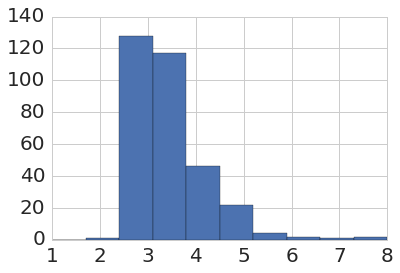

In [34]:
interface_mutation_features_df_final['contact_distance_wt'].hist(range=(1, 8.0))

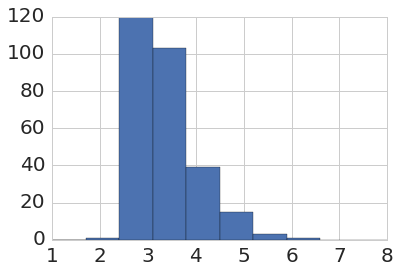

In [35]:
interface_mutation_features_df_final = (
    interface_mutation_features_df_final.drop_duplicates(['pdb_id', 'pdb_mutation']))
interface_mutation_features_df_final['contact_distance_wt'].hist(range=(1, 8.0))

In [36]:
print2("Number of ELASPIC PDB mutations wddg_exp:", 
       interface_mutation_features_df_final.shape[0])
print2("Number of ELASPIC PDB mutation indexes wddg_exp:",
       len(set(interface_mutation_features_df_final.index)))
print2("Number of unique ELASPIC pdb id / mutations wddg_exp:",
       interface_mutation_features_df_final[['pdb_id', 'pdb_mutation']].drop_duplicates().shape[0])

Number of ELASPIC PDB mutations wddg_exp:                   282
Number of ELASPIC PDB mutation indexes wddg_exp:            282
Number of unique ELASPIC pdb id / mutations wddg_exp:       282


## Save to database

In [37]:
_header_columns = [
    'pdb_id', 'pdb_chain', 'partner_pdb_chain', 'pdb_mutation', 'mutation', 'mutation_modeller', 'idx', 'idxs',
]

In [38]:
interface_mutation_features_df_final[
    _header_columns + [c for c in interface_mutation_features_df_final.columns if c not in _header_columns]
].head(2)

,pdb_id,pdb_chain,partner_pdb_chain,pdb_mutation,mutation,mutation_modeller,idx,idxs,alignment_coverage,alignment_identity,alignment_score,analyse_complex_energy_mut,analyse_complex_energy_wt,chain_modeller,contact_distance_mut,contact_distance_wt,ddg,interface_area_hydrophilic,interface_area_hydrophobic,interface_area_total,matrix_score,model_file_mut,model_file_wt,mutation_errors,norm_dope,physchem_mut,physchem_mut_ownchain,physchem_wt,physchem_wt_ownchain,provean_score,secondary_structure_mut,secondary_structure_wt,solvent_accessibility_mut,solvent_accessibility_wt,stability_energy_mut,stability_energy_wt,ddg_exp
256,1gc1,C,NaN,S42A,S42A,S339A,1,"[0, 1]",100.0,100.0,1.0,"41.9659,131.714,-6.54501,-4.0065,-7.56168,-18....","41.9676,131.714,-4.85885,-4.0074,-7.59593,-18....",C,2.930740,2.101380,-1.041795,256.830,430.720,687.56,1,/home/kimlab1/database_data/biodb/recipes/prot...,/home/kimlab1/database_data/biodb/recipes/prot...,,-0.199640,"0,0,0,20","0,0,0,14","0,0,4,20","0,0,1,14",-2.19,T,T,64.068365,61.981030,"245.555,-255.403,-135.516,-553.462,-18.2303,74...","246.905,-255.404,-136.813,-553.727,-18.2333,74...",0.0
374,3hfm,Y,NaN,N93A,N93A,N307A,2,"[0, 2]",100.0,100.0,1.0,"43.8084,81.7971,5.04336,-1.06577,-1.71866,-4.8...","43.8147,81.7971,4.18029,-1.10015,-2.79955,-5.0...",Y,2.431894,2.431894,0.578378,168.485,67.335,235.82,-2,/home/kimlab1/database_data/biodb/recipes/prot...,/home/kimlab1/database_data/biodb/recipes/prot...,,-0.404127,"0,0,0,9","0,0,0,17","0,0,1,9","0,0,5,21",-1.01,H,H,50.884576,49.746769,"222.206,-171.387,-100.349,-375.476,-8.89289,51...","221.244,-172.095,-102.061,-376.182,-8.89289,51...",0.6


In [39]:
t = db.import_df(
    interface_mutation_features_df_final
    [_header_columns + [c for c in interface_mutation_features_df_final.columns if c not in _header_columns]],
    'kortemme_baker_elaspic_scores',
)

In [40]:
t.name

'kortemme_baker_elaspic_scores'

In [41]:
db.create_indexes(
    t.name,
    [(['pdb_id', 'pdb_chain', 'partner_pdb_chain', 'pdb_mutation'], True)]
)

In [42]:
db.add_idx_column(t.name, '_index')

282

----

# Skempi

In [43]:
skempi_df = DATA['skempi'].copy()

In [44]:
skempi_df.shape

(2213, 11)

In [45]:
skempi_df['pdb_file'] = (
    PDB_DIR + ('/pdb' + skempi_df['pdb_id'] + '.ent.gz')
)

In [46]:
skempi_df_tocalculate = (
    skempi_df
    .groupby(['pdb_id', 'pdb_file'])
    .agg({'pdb_mutation': lambda x: ':'.join(ascommon.py_tools.unique(x))})
    .reset_index()
)

display(skempi_df_tocalculate.head())
print(skempi_df_tocalculate.shape[0])

,pdb_id,pdb_file,pdb_mutation
0,1a22,/home/kimlab1/database_data/pdb/data/data/stru...,C182A:D171A:D26A:E174A:E186A:E56A:E65A:E66A:F1...
1,1a4y,/home/kimlab1/database_data/pdb/data/data/stru...,E108A:H84A:H114A:H8A:H13A:K40G:K40Q:N68A:Q12A:...
2,1acb,/home/kimlab1/database_data/pdb/data/data/stru...,L45D:L45E:L45G:L45I:L45P:L45S
3,1ahw,/home/kimlab1/database_data/pdb/data/data/stru...,"D178A:K149A,D150A:K165A,K166A:L176A:N199A:T121..."
4,1ak4,/home/kimlab1/database_data/pdb/data/data/stru...,A488G:A488V:A492G:A492V:G489A:G489V:H487A:H487...


72


In [47]:
system_command_template = """\
mkdir -p '{tempdir}' && \
cd '{tempdir}' && \
elaspic run -p '{pdb_file}' -m '{mutation}' -n 1 \
    --pdb_dir='/home/kimlab1/database_data/pdb/data/data/structures/divided/pdb/' \
    --blast_db_dir='/home/strokach/databases/blast/db' \
    --archive_dir='/home/kimlab1/database_data/elaspic_v2/'
"""

SUFFIX = '_1'
JOB_NAME = 'elaspic_run_skempi{}'.format(SUFFIX)

skempi_df_tocalculate['system_command'] = (
    skempi_df_tocalculate.apply(
        lambda x: system_command_template.format(
            tempdir=op.abspath(op.join(NOTEBOOK_NAME, JOB_NAME, x['pdb_id'].lower())),
            pdb_file=x['pdb_file'],
            mutation=x['pdb_mutation']),
        axis=1)
)

In [48]:
display(skempi_df_tocalculate.head())
print(skempi_df_tocalculate.shape[0])

,pdb_id,pdb_file,pdb_mutation,system_command
0,1a22,/home/kimlab1/database_data/pdb/data/data/stru...,C182A:D171A:D26A:E174A:E186A:E56A:E65A:E66A:F1...,mkdir -p '/home/kimlab1/database_data/biodb/re...
1,1a4y,/home/kimlab1/database_data/pdb/data/data/stru...,E108A:H84A:H114A:H8A:H13A:K40G:K40Q:N68A:Q12A:...,mkdir -p '/home/kimlab1/database_data/biodb/re...
2,1acb,/home/kimlab1/database_data/pdb/data/data/stru...,L45D:L45E:L45G:L45I:L45P:L45S,mkdir -p '/home/kimlab1/database_data/biodb/re...
3,1ahw,/home/kimlab1/database_data/pdb/data/data/stru...,"D178A:K149A,D150A:K165A,K166A:L176A:N199A:T121...",mkdir -p '/home/kimlab1/database_data/biodb/re...
4,1ak4,/home/kimlab1/database_data/pdb/data/data/stru...,A488G:A488V:A492G:A492V:G489A:G489V:H487A:H487...,mkdir -p '/home/kimlab1/database_data/biodb/re...


72


In [49]:
system_command = skempi_df_tocalculate.loc[0, 'system_command']
print(system_command)

mkdir -p '/home/kimlab1/database_data/biodb/recipes/elaspic_training_set/notebooks/elaspic_standalone_training_interface/elaspic_run_skempi_1/1a22' && cd '/home/kimlab1/database_data/biodb/recipes/elaspic_training_set/notebooks/elaspic_standalone_training_interface/elaspic_run_skempi_1/1a22' && elaspic run -p '/home/kimlab1/database_data/pdb/data/data/structures/all/pdb/pdb1a22.ent.gz' -m 'C182A:D171A:D26A:E174A:E186A:E56A:E65A:E66A:F176A:F191A:F10A:F25A:F25A,Y42A,Q46A:F54A:G187A:H18A:H21A:I179A:I4A:I58A:K168A:K172A:K70A:L6A:L9A:L15A:L45A:L73A:M14A:N12A:N63A:P5A:P48A:P59A:P61A:Q181A:Q22A:Q29A:Q46A:Q68A:Q69A:R167A:R178A:R183A:R8A:R16A:R19A:R64A:S184A:S188A:S7A:S51A:S55A:S57A:S62A:S71A:T175A:T3A:V180A:V185A:Y164A:Y42A:Y42A,Q46A:C308A:C322A:D319A,E320A,K321A:D326A:D332A:D352A,R356A,E358A:D364A:D405A:E282A:E291A:E320A:E327A:E373A:E375A:E380A:E383A,K385A,K387A,D390A:E407A:E409A:E424A:E242A:E244A:E275A:E279A:F296S:F300A:I303A:I305A:I328A:I365A:K310A:K321A:K367A:K379A:K403A:K403A,D405A,K406A,

## SGE

In [50]:
PATH = (
    '/home/kimlab1/strokach/anaconda/bin:/usr/local/bin:/bin:/usr/bin:/usr/local/sbin:/usr/sbin:/sbin'
)

js_beagle = ascommon.cluster_tools.JobSubmitter(
    JOB_NAME, 'sge://:@192.168.6.201', op.abspath(NOTEBOOK_NAME),
    email='ostrokach@gmail.com', force_new_folder=False,
    nproc=1, queue='medium', walltime='8:00:00', mem='6G',
    env={'PATH': PATH}
)

In [51]:
js_beagle.job_name

'elaspic_run_skempi_1'

In [52]:
skempi_df_tocalculate['PDB_ID'] = skempi_df_tocalculate['pdb_id'].str.upper()

In [53]:
skempi_df_tocalculate.reset_index()[['PDB_ID', 'system_command']].values.tolist()[:1]

[['1A22',
  "mkdir -p '/home/kimlab1/database_data/biodb/recipes/elaspic_training_set/notebooks/elaspic_standalone_training_interface/elaspic_run_skempi_1/1a22' && cd '/home/kimlab1/database_data/biodb/recipes/elaspic_training_set/notebooks/elaspic_standalone_training_interface/elaspic_run_skempi_1/1a22' && elaspic run -p '/home/kimlab1/database_data/pdb/data/data/structures/all/pdb/pdb1a22.ent.gz' -m 'C182A:D171A:D26A:E174A:E186A:E56A:E65A:E66A:F176A:F191A:F10A:F25A:F25A,Y42A,Q46A:F54A:G187A:H18A:H21A:I179A:I4A:I58A:K168A:K172A:K70A:L6A:L9A:L15A:L45A:L73A:M14A:N12A:N63A:P5A:P48A:P59A:P61A:Q181A:Q22A:Q29A:Q46A:Q68A:Q69A:R167A:R178A:R183A:R8A:R16A:R19A:R64A:S184A:S188A:S7A:S51A:S55A:S57A:S62A:S71A:T175A:T3A:V180A:V185A:Y164A:Y42A:Y42A,Q46A:C308A:C322A:D319A,E320A,K321A:D326A:D332A:D352A,R356A,E358A:D364A:D405A:E282A:E291A:E320A:E327A:E373A:E375A:E380A:E383A,K385A,K387A,D390A:E407A:E409A:E424A:E242A:E244A:E275A:E279A:F296S:F300A:I303A:I305A:I328A:I365A:K310A:K321A:K367A:K379A:K403A:K403A

## Resubmit failed

In [54]:
# Get job status
results_df = (
    js_beagle.job_status(
        skempi_df_tocalculate.reset_index()[['PDB_ID', 'system_command']].values.tolist()))
print(Counter(results_df['status']))

Counter({'misformed output': 70, 'missing': 2})


In [55]:
# Job statistics
failed = (
    set(results_df[~results_df['status'].isin(['done', 'misformed output'])]['job_id'])
)
system_commands_remaining = (
    skempi_df_tocalculate[
        (skempi_df_tocalculate['PDB_ID'].isin(failed))
    ]
)
print(len(system_commands_remaining))

2


In [56]:
system_commands_remaining['system_command'].values[0]

"mkdir -p '/home/kimlab1/database_data/biodb/recipes/elaspic_training_set/notebooks/elaspic_standalone_training_interface/elaspic_run_skempi_1/2qj9' && cd '/home/kimlab1/database_data/biodb/recipes/elaspic_training_set/notebooks/elaspic_standalone_training_interface/elaspic_run_skempi_1/2qj9' && elaspic run -p '/home/kimlab1/database_data/pdb/data/data/structures/all/pdb/pdb2qj9.ent.gz' -m 'A74T,M78L,K79G,Y80L:A74T,M78L,K79G,Y80L,G42H,D46E,A61T,I62M' -n 1     --pdb_dir='/home/kimlab1/database_data/pdb/data/data/structures/divided/pdb/'     --blast_db_dir='/home/strokach/databases/blast/db'     --archive_dir='/home/kimlab1/database_data/elaspic_v2/'\n"

Mutations affecting multiple amino acids will not be calculated. I think this is some of the mutations failed.

## Results

This part is a hack on top of a hack because ELASPIC does not save chain ids...
We remove mutations that affect multiple interfaces in the PDB (using 4.25 A as the threshold for duplicate).

### Read results

In [57]:
ls $NOTEBOOK_NAME/$JOB_NAME/1a22/.elaspic | head

1A22AB.pdb
1A22A.fasta
1A22A.pdb
1A22B.fasta
1A22B.pdb
model/
model.json
mutation_A_C182A.json
mutation_A_D171A.json
mutation_A_D26A.json


In [58]:
def load_json(file):
    try:
        with open(file, 'rt') as ifh:
            return json.load(ifh)
    except:
        print(file)
        return {}


skempi_df['mutation_json'] = (
    skempi_df[['pdb_id', 'pdb_chain', 'pdb_mutation']].apply(
        lambda x: load_json(
            op.join(
                NOTEBOOK_NAME,
                JOB_NAME,
                x[0].lower(),
                '.elaspic',
                'mutation_{}_{}.json'.format(x[1], x[2]))),
        axis=1)
)

elaspic_standalone_training_interface/elaspic_run_skempi_1/1brs/.elaspic/mutation_A_H102Q,R59A.json
elaspic_standalone_training_interface/elaspic_run_skempi_1/1brs/.elaspic/mutation_A_H102Q,R59K.json
elaspic_standalone_training_interface/elaspic_run_skempi_1/2j0t/.elaspic/mutation_D_C1S,F12Y.json
elaspic_standalone_training_interface/elaspic_run_skempi_1/2j0t/.elaspic/mutation_D_T2L,V4S.json
elaspic_standalone_training_interface/elaspic_run_skempi_1/2j0t/.elaspic/mutation_D_T2L,V4S,S68A.json
elaspic_standalone_training_interface/elaspic_run_skempi_1/2j0t/.elaspic/mutation_D_T2S,V4A.json
elaspic_standalone_training_interface/elaspic_run_skempi_1/2j0t/.elaspic/mutation_D_T2S,V4A,S68Y.json
elaspic_standalone_training_interface/elaspic_run_skempi_1/2j0t/.elaspic/mutation_D_V69A,A103V.json
elaspic_standalone_training_interface/elaspic_run_skempi_1/1a22/.elaspic/mutation_A_F25A,Y42A,Q46A.json
elaspic_standalone_training_interface/elaspic_run_skempi_1/1a22/.elaspic/mutation_A_Y42A,Q46A.json
e

In [59]:
skempi_df.head(2)

,id,uniprot_id,partner_uniprot_id,uniprot_mutation,pdb_id,pdb_chain,partner_pdb_chain,pdb_mutation,pfam_id,pfam_clan,ddg_exp,pdb_file,mutation_json
0,1,A0NA69,P01820,D71A,1dvf,D,B,D52A,None,None,1.682290,/home/kimlab1/database_data/pdb/data/data/stru...,"[{'matrix_score': -2, 'alignment_identity': 10..."
1,2,A0NA69,P01820,K49A,1dvf,D,B,K30A,None,None,1.003517,/home/kimlab1/database_data/pdb/data/data/stru...,"[{'matrix_score': -1, 'alignment_identity': 10..."


### PDB chain mapping

In [60]:
tempdir = tempfile.mkdtemp()

In [61]:
print(tempdir)

/tmp/strokach/tmp5ekc1o86


In [62]:
for (pdb_id, pdb_file) in skempi_df[['pdb_id', 'pdb_file']].drop_duplicates().values:
    with gzip.open(pdb_file) as ifh:
        with open(op.join(tempdir, '{}.pdb'.format(pdb_id)), 'wb') as ofh:
            ofh.write(ifh.read())

In [63]:
sps = {}
for (pdb_id, pdb_file) in skempi_df[['pdb_id', 'pdb_file']].drop_duplicates().values:
    sp = elaspic.structure_tools.StructureParser(op.join(tempdir, pdb_id + '.pdb'))
    sp.extract()
    sps[pdb_id] = sp

In [64]:
pdb_idx2chain = {}
pdb_chain2idx = {}
for pdb_id, sp in sps.items():
    pdb_idx2chain[pdb_id] = {i: chain_id for i, chain_id in enumerate(sp.chain_ids)}
    pdb_chain2idx[pdb_id] = {chain_id: i for i, chain_id in enumerate(sp.chain_ids)}

### ELASPIC features

In [65]:
skempi_df.head(2)

,id,uniprot_id,partner_uniprot_id,uniprot_mutation,pdb_id,pdb_chain,partner_pdb_chain,pdb_mutation,pfam_id,pfam_clan,ddg_exp,pdb_file,mutation_json
0,1,A0NA69,P01820,D71A,1dvf,D,B,D52A,None,None,1.682290,/home/kimlab1/database_data/pdb/data/data/stru...,"[{'matrix_score': -2, 'alignment_identity': 10..."
1,2,A0NA69,P01820,K49A,1dvf,D,B,K30A,None,None,1.003517,/home/kimlab1/database_data/pdb/data/data/stru...,"[{'matrix_score': -1, 'alignment_identity': 10..."


In [66]:
local.mutation_not_in_interface = 0
local.mutation_interface_not_found = 0

interface_mutation_features_df = pd.concat([
    local.guess_interface_mutation_features(index, mutation_json) 
    for index, mutation_json 
    in skempi_df.reset_index()[['index', 'mutation_json']].values])

print('mutation_not_in_interface:', local.mutation_not_in_interface)
print('mutation_interface_not_found', local.mutation_interface_not_found)

mutation_not_in_interface: 795
mutation_interface_not_found 0


In [67]:
interface_mutation_features_df.head(2)

,alignment_coverage,alignment_identity,alignment_score,analyse_complex_energy_mut,analyse_complex_energy_wt,chain_modeller,contact_distance_mut,contact_distance_wt,ddg,idx,idxs,interface_area_hydrophilic,interface_area_hydrophobic,interface_area_total,matrix_score,model_file_mut,model_file_wt,mutation,mutation_errors,mutation_modeller,norm_dope,physchem_mut,physchem_mut_ownchain,physchem_wt,physchem_wt_ownchain,provean_score,secondary_structure_mut,secondary_structure_wt,solvent_accessibility_mut,solvent_accessibility_wt,stability_energy_mut,stability_energy_wt
0,100.0,100.0,1.0,"20.6551,19.4474,-12.2334,-4.50859,-8.71871,-10...","21.4336,19.4474,-11.9096,-4.50859,-8.74835,-10...",D,5.406324,3.272212,1.048552,3,"[1, 3]",949.465,207.72,1157.19,-2,/home/kimlab1/database_data/biodb/recipes/prot...,/home/kimlab1/database_data/biodb/recipes/prot...,D52A,,D168A,-1.284799,"0,0,0,0","0,0,0,26","1,0,0,2","0,0,0,29",-4.954,E,E,5.740528,13.791581,"18.9585,-146.063,-80.8575,-266.194,-11.7789,36...","13.4651,-146.696,-81.5276,-267.103,-13.1652,36..."
1,100.0,100.0,1.0,"21.3695,19.4474,-11.9612,-4.50859,-8.74835,-10...","21.441,19.4474,-11.9096,-4.50859,-8.74835,-10....",D,3.448053,3.448053,0.583188,3,"[1, 3]",949.465,207.72,1157.19,-1,/home/kimlab1/database_data/biodb/recipes/prot...,/home/kimlab1/database_data/biodb/recipes/prot...,K30A,,K146A,-1.284799,"0,0,0,0","0,0,0,21","0,0,0,0","0,0,0,23",-2.385,G,G,32.530987,53.794731,"14.0401,-146.637,-79.8456,-266.328,-13.0643,36...","13.4592,-146.696,-81.5634,-267.087,-13.1653,36..."


In [68]:
interface_mutation_features_df_final = (
    interface_mutation_features_df
    .merge(
        skempi_df[['pdb_id', 'pdb_chain', 'partner_pdb_chain', 'pdb_mutation', 'ddg_exp']],
        left_index=True, right_index=True)
)

print2("Starting number of mutations:", skempi_df.shape[0])
print2("Starting number of mutation indexes:", len(set(skempi_df.index)))
print2("Number of unique pdb id / mutations:", 
       skempi_df[['pdb_id', 'pdb_mutation']].drop_duplicates().shape[0])
print('-' * 80)

print2("Number of ELASPIC PDB mutations:", 
       interface_mutation_features_df.shape[0])
print2("Number of ELASPIC PDB mutation indexes:",
       len(set(interface_mutation_features_df.index)))
print2("Number of unique ELASPIC pdb id / mutations:",
       interface_mutation_features_df_final[['pdb_id', 'pdb_mutation']].drop_duplicates().shape[0])
print('-' * 80)

print2("Number of ELASPIC PDB mutations wddg_exp:", 
       interface_mutation_features_df_final.shape[0])
print2("Number of ELASPIC PDB mutation indexes wddg_exp:",
       len(set(interface_mutation_features_df_final.index)))
print2("Number of unique ELASPIC pdb id / mutations wddg_exp:",
       interface_mutation_features_df_final[['pdb_id', 'pdb_mutation']].drop_duplicates().shape[0])

Starting number of mutations:                               2213
Starting number of mutation indexes:                        2213
Number of unique pdb id / mutations:                        2210
--------------------------------------------------------------------------------
Number of ELASPIC PDB mutations:                            1577
Number of ELASPIC PDB mutation indexes:                     1418
Number of unique ELASPIC pdb id / mutations:                1415
--------------------------------------------------------------------------------
Number of ELASPIC PDB mutations wddg_exp:                   1577
Number of ELASPIC PDB mutation indexes wddg_exp:            1418
Number of unique ELASPIC pdb id / mutations wddg_exp:       1415


### Correct duplicate interfaces

In [69]:
interface_mutation_features_df_final = (
    interface_mutation_features_df_final.sort_values('contact_distance_wt', ascending=True))
interface_mutation_features_df_final.tail(2)

,alignment_coverage,alignment_identity,alignment_score,analyse_complex_energy_mut,analyse_complex_energy_wt,chain_modeller,contact_distance_mut,contact_distance_wt,ddg,idx,idxs,interface_area_hydrophilic,interface_area_hydrophobic,interface_area_total,matrix_score,model_file_mut,model_file_wt,mutation,mutation_errors,mutation_modeller,norm_dope,physchem_mut,physchem_mut_ownchain,physchem_wt,physchem_wt_ownchain,provean_score,secondary_structure_mut,secondary_structure_wt,solvent_accessibility_mut,solvent_accessibility_wt,stability_energy_mut,stability_energy_wt,pdb_id,pdb_chain,partner_pdb_chain,pdb_mutation,ddg_exp
45,100.0,100.0,1.0,"55.7309,26.2422,-3.57341,-2.55825,-8.28319,-6....","55.9494,26.2422,-4.39967,-2.57344,-8.28319,-6....",C,8.408519,7.103505,0.395374,2,"[1, 2]",848.47,97.840,946.305,-2,/home/kimlab1/database_data/biodb/recipes/prot...,/home/kimlab1/database_data/biodb/recipes/prot...,R125A,,R241A,-1.018821,"0,0,0,0","0,0,0,11","0,0,0,0","0,0,1,13",-1.768,T,T,67.433627,76.037737,"77.8161,-151.151,-88.7621,-285.268,-6.12651,39...","77.2316,-151.198,-91.6007,-285.844,-6.53069,39...",1vfb,C,A,R125A,1.836900
489,100.0,100.0,1.0,"70.6751,54.9888,-19.3333,-3.57726,-11.0745,-23...","70.9956,54.9888,-18.7396,-3.57703,-11.0715,-23...",B,8.620477,7.844493,0.624938,1,"[0, 1]",984.92,418.785,1403.705,-1,/home/kimlab1/database_data/biodb/recipes/prot...,/home/kimlab1/database_data/biodb/recipes/prot...,E128A,,E308A,-0.806891,"0,0,0,0","0,0,0,29","0,0,0,0","0,2,0,36",-3.767,E,E,8.180547,5.665254,"90.9283,-231.001,-125.215,-457.878,-13.5018,60...","91.5803,-232.002,-125.746,-459.682,-15.2834,60...",1a22,B,A,E373A,0.082765


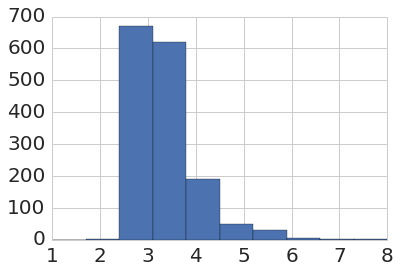

In [70]:
interface_mutation_features_df_final['contact_distance_wt'].hist(range=(1, 8.0))

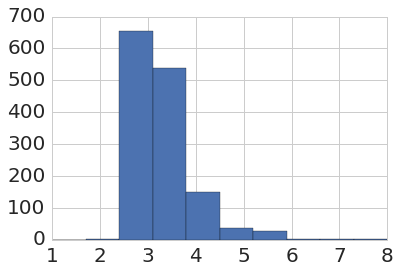

In [71]:
interface_mutation_features_df_final = (
    interface_mutation_features_df_final.drop_duplicates(['pdb_id', 'pdb_mutation']))
interface_mutation_features_df_final['contact_distance_wt'].hist(range=(1, 8.0))

In [72]:
print2("Number of ELASPIC PDB mutations wddg_exp:", 
       interface_mutation_features_df_final.shape[0])
print2("Number of ELASPIC PDB mutation indexes wddg_exp:",
       len(set(interface_mutation_features_df_final.index)))
print2("Number of unique ELASPIC pdb id / mutations wddg_exp:",
       interface_mutation_features_df_final[['pdb_id', 'pdb_mutation']].drop_duplicates().shape[0])

Number of ELASPIC PDB mutations wddg_exp:                   1415
Number of ELASPIC PDB mutation indexes wddg_exp:            1415
Number of unique ELASPIC pdb id / mutations wddg_exp:       1415


## Save to database

In [73]:
_header_columns = [
    'pdb_id', 'pdb_chain', 'partner_pdb_chain', 'pdb_mutation', 'mutation', 'mutation_modeller', 'idx', 'idxs',
]

In [74]:
interface_mutation_features_df_final[
    _header_columns + [c for c in interface_mutation_features_df_final.columns if c not in _header_columns]
].head(2)

,pdb_id,pdb_chain,partner_pdb_chain,pdb_mutation,mutation,mutation_modeller,idx,idxs,alignment_coverage,alignment_identity,alignment_score,analyse_complex_energy_mut,analyse_complex_energy_wt,chain_modeller,contact_distance_mut,contact_distance_wt,ddg,interface_area_hydrophilic,interface_area_hydrophobic,interface_area_total,matrix_score,model_file_mut,model_file_wt,mutation_errors,norm_dope,physchem_mut,physchem_mut_ownchain,physchem_wt,physchem_wt_ownchain,provean_score,secondary_structure_mut,secondary_structure_wt,solvent_accessibility_mut,solvent_accessibility_wt,stability_energy_mut,stability_energy_wt,ddg_exp
293,1gc1,C,G,S42A,S42A,S339A,1,"[0, 1]",100.0,100.0,1.0,"41.9659,131.714,-6.54501,-4.0065,-7.56168,-18....","41.9676,131.714,-4.85885,-4.0074,-7.59593,-18....",C,2.93074,2.101380,-1.041795,256.830,430.72,687.56,1,/home/kimlab1/database_data/biodb/recipes/prot...,/home/kimlab1/database_data/biodb/recipes/prot...,,-0.199640,"0,0,0,20","0,0,0,14","0,0,4,20","0,0,1,14",-2.190,T,T,64.068365,61.981030,"245.555,-255.403,-135.516,-553.462,-18.2303,74...","246.905,-255.404,-136.813,-553.727,-18.2333,74...",0.000000
130,2j0t,D,A,T2A,T2A,T163A,3,"[0, 3]",100.0,100.0,1.0,"31.5418,34.1706,-5.647,-7.83505,-2.13059,-13.6...","31.5419,34.1706,-4.7865,-7.8758,-2.64543,-14.2...",D,2.88516,2.178801,2.761585,189.175,290.78,479.96,0,/home/kimlab1/database_data/biodb/recipes/prot...,/home/kimlab1/database_data/biodb/recipes/prot...,,-1.043686,"0,0,0,31","0,0,0,5","0,0,1,36","0,0,1,5",-1.344,E,E,99.383511,103.129533,"111.667,-155.965,-79.502,-323.272,-7.41946,448...","112.14,-156.006,-80.0168,-323.921,-7.41946,449...",4.387813


In [75]:
t = db.import_df(
    interface_mutation_features_df_final
    [_header_columns + [c for c in interface_mutation_features_df_final.columns if c not in _header_columns]],
    'skempi_elaspic_scores',
)

In [76]:
t.name

'skempi_elaspic_scores'

In [77]:
db.create_indexes(
    t.name,
    [(['pdb_id', 'pdb_chain', 'partner_pdb_chain', 'pdb_mutation'], True)]
)

In [78]:
db.add_idx_column(t.name, '_index')

1415